In [ ]:
pip install scipy scikit-learn fastdtw matplotlib

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
from scipy.fft import fft, ifft
from sklearn.metrics import mean_squared_error
from itertools import product

In [ ]:
# === CONFIGURATION ===
DATA_DIR = "processed"  # Update path if needed


# finds the top closest match in K-DTW to predict where the new leak is. 
K = 3
# Controls how flexible the DTW comparison is across time.
MAX_WARPING_WINDOW = 30
# Reduce the size of data by taking every 2nd value, helps with speed.
SUBSAMPLE_STEP = 2

FFT_THRESHOLD = 0.005

In [ ]:
# === FFT Smoothing ===

# Removes noise from sensor data using FFT(Fast Fourier Transform). 
def fft_smooth(signal, threshold = FFT_THRESHOLD):
    # Keeps strong signal problems (like actual gas concentration changes) and removes weak patterns (random noise). 
    fft_vals = fft(signal)
    fft_magnitudes = np.abs(fft_vals)
    # Flatten(easier to analyze and visualize) the noise to keep the meaningful pattern. 
    fft_vals[fft_magnitudes < threshold * np.max(fft_magnitudes)] = 0
    return np.real(ifft(fft_vals))

In [ ]:
# === Load and Preprocess ===
def preprocess_csv(file_path):
    # Read csv file into memory (df = dataframe).
    df = pd.read_csv(file_path).dropna()
    # Keeps only the sensor columns p1 to p16.
    sensor_cols = [f"p{i}" for i in range(1, 17)]
    df = df[sensor_cols]

    # Prepares a list (smoothed) to hold cleaned data for each sensor.
    smoothed = []
    # for each sensor column
    for col in df.columns:
        # Smooths(reducing noise within dataset) the signal using the fft_smooth function. 
        series = fft_smooth(df[col].values)
        # normalizes the data (subtracts the mean and divides by standard deviation) --> makes all sensor signals comparable (same scale). 
        norm_series = (series - np.mean(series)) / np.std(series)
        smoothed.append(norm_series)
    
    # all 16 cleaned, normalized sensor signals are then combined together into one long 1D array. 
    # If each sensor has 2000 values, then all 16 sensors combined = 16 x 2000 => 32,000 values in one vector. 
    combined = np.concatenate(smoothed)
    # We use this by K-DTW for comparing tests. 
    return combined

In [ ]:
# Find all the csv files in the datasets folder that start with "test-" (like test-2.csv).
# This builds the training dataset for K-DTW. 
def load_all_data():
    X_data, y_coords, labels = [], [], []
    pattern = os.path.join(DATA_DIR, "*_test-*_range.csv")

    for file_path in glob.glob(pattern):
        name = os.path.basename(file_path).replace(".csv", "")

        full_df = pd.read_csv(file_path).dropna()
        x_coord = full_df["X"].iloc[0]
        z_coord = full_df["Z"].iloc[0]
        coord = (x_coord, z_coord)

        vector = preprocess_csv(file_path)

        X_data.append(vector)
        y_coords.append(coord)
        labels.append(name)

    return X_data, y_coords, labels

In [ ]:
# === DTW Distance with warping + subsampling ===

# This function compares two time series vectors (like one test and one train sample) using DTW. 
# Subsampling = reduces the data size. If step = 2, it uses every other point. 

# Creates a DTW matrix to store costs of aligning each point in test(1) to each point in test(2).
def dtw_distance(ts1, ts2, max_warping_window=np.inf, subsample_step=1):

    
    ts1 = ts1[::subsample_step]
    ts2 = ts2[::subsample_step]
    n, m = len(ts1), len(ts2)
    if np.isinf(max_warping_window) or max_warping_window > max(n, m):
        w = max(n, m)

    else:
        w = int(max_warping_window)

    prev = np.full(m+1, np.inf)
    prev[0] = 0.0


    for i in range(1, n+1):
        curr = np.full(m+1, np.inf)

        j_start = max(1, i - w)
        j_end = min(m, i + w)
        for j in range(j_start, j_end+1):
            cost = abs(ts1[i-1] - ts2[j-1])
            best_prev = min(prev[j], curr[j-1], prev[j-1])

            curr[j] = cost + best_prev
        prev = curr
    
    return prev[m]
    # # Fills the matrix by comparing each point in the two sequences.
    # # Finding the lowest-cost way to align them. 
    # # n, m = len(ts1), len(ts2)
    # # dtw_matrix = np.full((n + 1, m + 1), np.inf)
    # # dtw_matrix[0, 0] = 0

    
    # for i in range(1, n + 1):
    #     for j in range(max(1, i - int(max_warping_window)), min(m + 1, i + int(max_warping_window))):
    #         cost = abs(ts1[i - 1] - ts2[j - 1])
    #         dtw_matrix[i, j] = cost + min(
    #             dtw_matrix[i - 1, j],
    #             dtw_matrix[i, j - 1],
    #             dtw_matrix[i - 1, j - 1]
    #         )
    # # Returns the final alignment cost, smaller means the two time series are more similar. 
    # return dtw_matrix[n, m]


# This function uses DTW to find the closest match in time-evolving patterns, even if events (like peak gas arrival) happen at different times. 
# Finds the minimum "cost" to make ts1 look like ts2, whcih means they are similar gas leak patterns.

In [ ]:
# === K-DTW Regressor ===

# takes in a test vector (sensor data of unknown leak) and compares it to all known vectors (training data).
def k_dtw_predict(test_vec, train_vecs, train_labels, k=1, max_warping_window=np.inf, subsample_step=1):

    # Uses DTW distance to measure how similar each one is.
    distances = []
    for i, vec in enumerate(train_vecs):
        dist = dtw_distance(test_vec, vec, max_warping_window, subsample_step)
        distances.append((dist, train_labels[i]))

    # Sorts them to find the top K closest matches. 
    distances.sort(key=lambda x: x[0])
    nearest = [label for _, label in distances[:k]]

    # Averages their known coordinates [X, Z] to predict the leak location of the test. 
    return np.mean(nearest, axis=0)

In [ ]:
X_all, y_all, labels = load_all_data()
wanted = {"07_test-7_range", "12_test-12_range"}
selected_idxs = [i for i, lbl in enumerate(labels) if lbl in wanted]

In [ ]:
results = []
for i in selected_idxs:
    test_label = labels[i]
    test_X = X_all[i]
    true_x, true_z = y_all[i]

    train_X = [x for j, x in enumerate(X_all) if j != i]
    train_y = [y for j, y in enumerate(y_all) if j != i]

    pred_x, pred_z = k_dtw_predict(
        test_X,
        train_X,
        train_y,
        k=K,
        max_warping_window = MAX_WARPING_WINDOW,
        subsample_step = SUBSAMPLE_STEP
    )

    results.append({
        "Test": test_label,
        "True_X": true_x,
        "True_Z": true_z,
        "Pred_X": pred_x,
        "Pred_Z": pred_z
    })

results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
results_df.to_csv("test7_12_results.csv")
print("saved")

In [ ]:
# # === Full Leave-One-Out Pipeline ===
# def run_pipeline():

#     # Loads all the sensor vectors and known leak locations.
#     X_all, y_all, label_names = load_all_data()

#     results = []

#     # Loops through each sample and treats it like a test case (one at a time). 
#     for i in range(len(X_all)):
#         test_X = X_all[i]
#         test_y = np.array(y_all[i])
#         test_label = label_names[i]
#         #print (test_X.shape(), test_y.shape())

#         # The rest of the data is used as the training set. 
#         train_X = [x for j, x in enumerate(X_all) if j != i]
#         train_y = [y for j, y in enumerate(y_all) if j != i]
#         print (train_X, train_y)
#         # Uses k_dtw_predict() to predict the leak location
#         pred = k_dtw_predict(test_X, train_X, train_y, k=K,
#                              max_warping_window=MAX_WARPING_WINDOW,
#                              subsample_step=SUBSAMPLE_STEP)
        
#         error_vals = abs((pred-test_y) / test_y) * 100
#         error = error_vals.mean()

#         # # Calculate the error between predicted and actual [X, Z]. 
#         # error = abs((pred - test_y)/test_y)*100
#         results.append({
#             "Test": test_label,
#             "True_X": test_y[0], "True_Z": test_y[1],
#             "Pred_X": pred[0], "Pred_Z": pred[1],
#             "Error": error
#         })

#     # Stores the result into a table
#     return pd.DataFrame(results)



In [ ]:
# # Run pipeline and show results
# results_df = run_pipeline()
# results_df

# Parity Plot

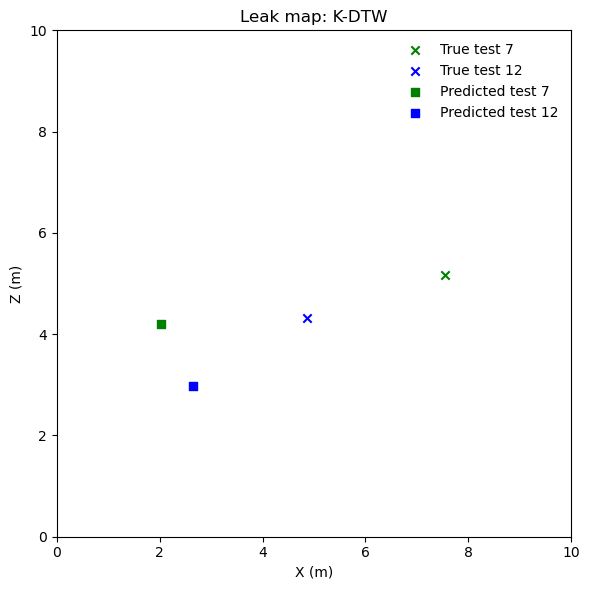

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('test7_12_results.csv')

df['True_X_n'] = -df['True_X']
df['True_Z_n'] = -df['True_Z']
df['Pred_X_n'] = -df['Pred_X']
df['Pred_Z_n'] = -df['Pred_Z']

df7 = df[df['Test'].str.contains('test-7', case=False)]
df12 = df[df['Test'].str.contains('test-12', case=False)]


plt.figure(figsize=(6,6))

plt.scatter(df7['True_X_n'], df7['True_Z_n'], marker = 'x', color = 'green', label='True test 7')
plt.scatter(df12['True_X_n'], df12['True_Z_n'], marker = 'x', color = 'blue', label = 'True test 12')

plt.scatter(df7['Pred_X_n'], df7['Pred_Z_n'], marker = 's', color='green', label = 'Predicted test 7')
plt.scatter(df12['Pred_X_n'], df12['Pred_Z_n'], marker = 's', color='blue', label = 'Predicted test 12')

plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('X (m)')
plt.ylabel('Z (m)')
plt.title('Leak map: K-DTW')

leg = plt.legend(frameon=True)
leg.get_frame().set_alpha(0.0)

plt.tight_layout()

plt.savefig('KDTW_parity_plot.png', dpi=400, transparent=True, bbox_inches='tight')
plt.show()

# K-DTW Results

In [11]:
import pandas as pd
import numpy as np

In [12]:
df = pd.read_csv('test7_12_results.csv')
df['d'] = np.sqrt(
    (df['True_X'] - df['Pred_X'])**2 + (df['True_Z'] - df['Pred_Z'])**2)

d7 = df.loc[df['Test'].str.contains('test-7', case=False), 'd'].iloc[0]
d12 = df.loc[df['Test'].str.contains('test-12', case=False), 'd'].iloc[0]

print(f"Distance for Test 7: {d7:.4f}")
print(f"Distance for Test 12: {d12:.4f}")

Distance for Test 7: 5.6001
Distance for Test 12: 2.5932


# PLOT GRAPH

In [ ]:
import matplotlib.pyplot as plt

tests = results_df["Test"].tolist()
true_x = results_df["True_X"].tolist()
pred_x = results_df["Pred_X"].tolist()
true_z = results_df["True_Z"].tolist()
pred_z = results_df["Pred_Z"].tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharey=False)
ax1.plot(tests, true_x, marker = "o", label= "True X", linestyle="None")
ax1.plot(tests, pred_x, marker = "s", label= "Predicted X", linestyle="None")


plt.ylim([-6,-3])

ax1.set_title("True vs. Predicted X")
ax1.set_xlabel("Test")
#ax1.set_ylabel("X Coordinate")
ax1.legend()
#ax1.grid(True)
ax1.set_xticks(tests)
ax1.set_xticklabels(tests, rotation=30, ha="right")

ax2.plot(tests, true_z, marker = "o", label="True Z", linestyle="None")
ax2.plot(tests, pred_z, marker = "s", label="Predicted Z", linestyle="None")




ax2.set_title("True vs. Predicted Z")
#ax1.set_xlabel("Test")
#ax1.set_ylabel("Z Coordinate")
ax2.legend()
#ax2.grid(True)
ax2.set_xticks(tests)
ax2.set_xticklabels(tests, rotation=30, ha="right")

ax1.set_ylim(-6, -3)
ax2.set_ylim(-6, -3)

plt.tight_layout()
plt.show()

In [ ]:
if __name__ == "__main__":
    results_df= run_pipeline() 

    print("Final predicted coordinates:\n")
    for _, row in results_df.iterrows():
        test = row["Test"]
        pred_x = row["Pred_X"]
        pred_z = row["Pred_Z"]

        print(f"{test:>6} -> [X, Z] = [{pred_x:.6f}, {pred_z:.6f}]")

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd


# plt.figure(figsize = (6,6))
# plt.scatter(
#     results_df['True_X'],
#     results_df['True_Z'], 
#     marker='o',
#     color='blue',
#     label='True'
# )

# plt.scatter(
#     results_df['Pred_X'],
#     results_df['Pred_Z'],
#     marker = 'x',
#     color='red',
#     label='Predicted'
# )

# for _, row in results_df.iterrows():
#     plt.plot(
#         [row['True_X'], row['Pred_X']],
#         [row['True_Z'], row['Pred_Z']],
#         linestyle='--',
#         color='gray'
#     )

#     plt.text(
#         row['Pred_X'],
#         row['Pred_Z'],
#         row['Test'],
#         color='blue',
#         fontsize=9,
#         verticalalignment='bottom',
#         horizontalalignment = 'right'
#     )

#     plt.text(
#         row['Pred_X'],
#         row['Pred_Z'],
#         row['Test'],
#         color='red',
#         fontsize=9,
#         verticalalignment='top',
#         horizontalalignment='left'
#     )

# plt.xlabel('X') 
# plt.ylabel('Z')
# plt.title('True vs Predicted')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show() 